In [ ]:
#|default_exp callback.PredictionDynamics

# PredictionDynamics

>Callback used to visualize model predictions during training.

This is an implementation created by Ignacio Oguiza (oguiza@timeseriesAI.co) based on a [blog post](http://localhost:8888/?token=83bca9180c34e1c8991886445942499ee8c1e003bc0491d0) by Andrej Karpathy I read some time ago that I really liked. One of the things he mentioned was this: 

>"**visualize prediction dynamics**. I like to visualize model predictions on a fixed test batch during the course of training. The “dynamics” of how these predictions move will give you incredibly good intuition for how the training progresses. Many times it is possible to feel the network “struggle” to fit your data if it wiggles too much in some way, revealing instabilities. Very low or very high learning rates are also easily noticeable in the amount of jitter." A. Karpathy


In [ ]:
#|export
from fastai.callback.all import *
from tsai.imports import *

In [ ]:
#|export
class PredictionDynamics(Callback):
    order, run_valid = 65, True

    def __init__(self, show_perc=1., figsize=(10,6), alpha=.3, size=30, color='lime', cmap='gist_rainbow', normalize=False, 
                 sensitivity=None, specificity=None):

        """
        Args:
            show_perc:   percent of samples from the valid set that will be displayed. Default: 1 (all).
                         You can reduce it if the number is too high and the chart is too busy.
            alpha:       level of transparency. Default:.3. 1 means no transparency.
            figsize:     size of the chart. You may want to expand it if too many classes.
            size:        size of each sample in the chart. Default:30. You may need to decrease it a bit if too many classes/ samples.
            color:       color used in regression plots.
            cmap:        color map used in classification plots.
            normalize:   flag to normalize histograms displayed in binary classification.
            sensitivity: (aka recall or True Positive Rate) if you pass a float between 0. and 1. the sensitivity threshold will be plotted in the chart.
                         Only used in binary classification.
            specificity: (or True Negative Rate) if you pass a float between 0. and 1. it will be plotted in the chart. Only used in binary classification.

        The red line in classification tasks indicate the average probability of true class.
        """

        store_attr()

    def before_fit(self):
        self.run = not hasattr(self.learn, 'lr_finder') and not hasattr(self, "gather_preds")
        if not self.run:
            return
        self.cat = True if (hasattr(self.dls, "c") and self.dls.c > 1) else False
        if self.cat:
            self.binary = self.dls.c == 2
        if self.show_perc != 1:
            valid_size = len(self.dls.valid.dataset)
            self.show_idxs = random_choice(valid_size, int(round(self.show_perc * valid_size)), replace=False)

        # Prepare ground truth container
        self.y_true = []

    def before_epoch(self):
        # Prepare empty pred container in every epoch
        self.y_pred = []

    def after_pred(self):
        if self.training:
            return

        # Get y_true in epoch 0
        if self.epoch == 0:
            self.y_true.extend(self.y.cpu().flatten().numpy())

        # Gather y_pred for every batch
        if self.cat:
            if self.binary:
                y_pred = F.softmax(self.pred, -1)[:, 1].reshape(-1, 1).cpu()
            else:
                y_pred = torch.gather(F.softmax(self.pred, -1), -1, self.y.reshape(-1, 1).long()).cpu()
        else:
            y_pred = self.pred.cpu()
        self.y_pred.extend(y_pred.flatten().numpy())

    def after_epoch(self):
        # Ground truth
        if self.epoch == 0:
            self.y_true = np.array(self.y_true)
            if self.show_perc != 1:
                self.y_true = self.y_true[self.show_idxs]
            self.y_bounds = (np.min(self.y_true), np.max(self.y_true))
            self.min_x_bounds, self.max_x_bounds = np.min(self.y_true), np.max(self.y_true)

        self.y_pred = np.array(self.y_pred)
        if self.show_perc != 1:
            self.y_pred = self.y_pred[self.show_idxs]
        if self.cat:
            neg_thr = None
            pos_thr = None
            if self.specificity is not None: 
                inp0 = self.y_pred[self.y_true == 0]
                neg_thr = np.sort(inp0)[-int(len(inp0) * (1 - self.specificity))]
            if self.sensitivity is not None: 
                inp1 = self.y_pred[self.y_true == 1]
                pos_thr = np.sort(inp1)[-int(len(inp1) * self.sensitivity)]
            self.update_graph(self.y_pred, self.y_true, neg_thr=neg_thr, pos_thr=pos_thr)
        else:
            # Adjust bounds during validation
            self.min_x_bounds = min(self.min_x_bounds, np.min(self.y_pred))
            self.max_x_bounds = max(self.max_x_bounds, np.max(self.y_pred))
            x_bounds = (self.min_x_bounds, self.max_x_bounds)
            self.update_graph(self.y_pred, self.y_true, x_bounds=x_bounds, y_bounds=self.y_bounds)

    def update_graph(self, y_pred, y_true, x_bounds=None, y_bounds=None, neg_thr=None, pos_thr=None):
        if not hasattr(self, 'graph_fig'):
            self.df_out = display("", display_id=True)
            if self.cat:
                self._cl_names = self.dls.vocab
                self._classes = L(self.dls.vocab.o2i.values())
                self._n_classes = len(self._classes)
                if self.binary:
                    self.bins = np.linspace(0, 1, 101)
                else:
                    _cm = plt.get_cmap(self.cmap)
                    self._color = [_cm(1. * c/self._n_classes) for c in range(1, self._n_classes + 1)][::-1]
                    self._h_vals = np.linspace(-.5, self._n_classes - .5, self._n_classes + 1)[::-1]
                    self._rand = []
                    for i, c in enumerate(self._classes):
                        self._rand.append(.5 * (np.random.rand(np.sum(y_true == c)) - .5))
            self.graph_fig, self.graph_ax = plt.subplots(1, figsize=self.figsize)
            self.graph_out = display("", display_id=True)
        self.graph_ax.clear()
        if self.cat:
            if self.binary:
                self.graph_ax.hist(y_pred[y_true == 0], bins=self.bins, density=self.normalize,  color='red', label=self._cl_names[0],
                                          edgecolor='black', alpha=self.alpha)
                self.graph_ax.hist(y_pred[y_true == 1], bins=self.bins, density=self.normalize,  color='blue', label=self._cl_names[1],
                                          edgecolor='black', alpha=self.alpha)
                self.graph_ax.axvline(.5, lw=1, ls='--', color='gray')
                if neg_thr is not None: 
                    self.graph_ax.axvline(neg_thr, lw=2, ls='--', color='red', label=f'specificity={(self.specificity):.3f}')
                if pos_thr is not None: 
                    self.graph_ax.axvline(pos_thr, lw=2, ls='--', color='blue', label=f'sensitivity={self.sensitivity:.3f}')
                self.graph_ax.set_xlabel(f'probability of class {self._cl_names[1]}', fontsize=12)
                self.graph_ax.legend()
            else:
                for i, c in enumerate(self._classes):
                    self.graph_ax.scatter(y_pred[y_true == c], y_true[y_true == c] + self._rand[i],  color=self._color[i],
                                          edgecolor='black', alpha=self.alpha, lw=.5, s=self.size)
                    self.graph_ax.vlines(np.mean(y_pred[y_true == c]), i - .5, i + .5, color='r')
                self.graph_ax.vlines(.5, min(self._h_vals), max(self._h_vals), lw=.5)
                self.graph_ax.hlines(self._h_vals, 0, 1, lw=.5)
                self.graph_ax.set_ylim(min(self._h_vals), max(self._h_vals))
                self.graph_ax.set_yticks(self._classes)
                self.graph_ax.set_yticklabels(self._cl_names)
                self.graph_ax.set_ylabel('true class', fontsize=12)
                self.graph_ax.set_xlabel('probability of true class', fontsize=12)
            self.graph_ax.set_xlim(0, 1)
            self.graph_ax.set_xticks(np.linspace(0, 1, 11))
            self.graph_ax.grid(axis='x', color='gainsboro', lw=.2)
        else:
            self.graph_ax.scatter(y_pred, y_true, color=self.color, edgecolor='black', alpha=self.alpha, lw=.5, s=self.size)
            self.graph_ax.set_xlim(*x_bounds)
            self.graph_ax.set_ylim(*y_bounds)
            self.graph_ax.plot([*x_bounds], [*x_bounds], color='gainsboro')
            self.graph_ax.set_xlabel('y_pred', fontsize=12)
            self.graph_ax.set_ylabel('y_true', fontsize=12)
            self.graph_ax.grid(color='gainsboro', lw=.2)
        self.graph_ax.set_title(f'Prediction Dynamics \nepoch: {self.epoch + 1}/{self.n_epoch}')
        self.df_out.update(pd.DataFrame(np.stack(self.learn.recorder.values)[-1].reshape(1,-1),
                                        columns=self.learn.recorder.metric_names[1:-1], index=[self.epoch]))
        self.graph_out.update(self.graph_ax.figure)
        if self.epoch == self.n_epoch - 1: 
            plt.close(self.graph_ax.figure)

In [ ]:
from tsai.basics import *
from tsai.models.InceptionTime import *

In [ ]:
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, split_data=False)
check_data(X, y, splits, False)

X      - shape: [360 samples x 24 features x 51 timesteps]  type: memmap  dtype:float32  isnan: 0
y      - shape: (360,)  type: memmap  dtype:<U3  n_classes: 6 (60 samples per class) ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0']  isnan: False
splits - n_splits: 2 shape: [180, 180]  overlap: False


epoch,train_loss,valid_loss,accuracy,time
0,1.885462,1.773872,0.238889,00:05
1,1.425667,1.640418,0.377778,00:05


,train_loss,valid_loss,accuracy
1,1.425667,1.640418,0.377778


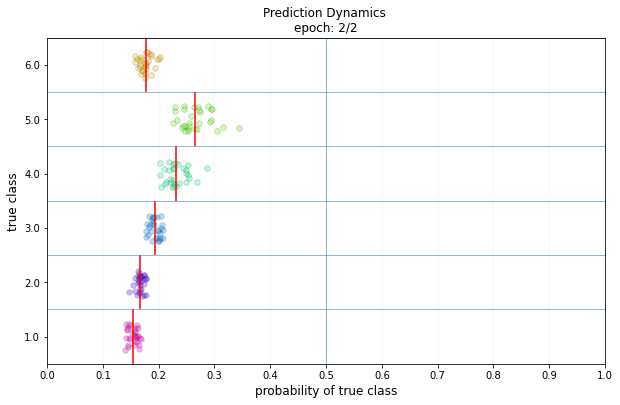

In [ ]:
tfms  = [None, [Categorize()]]
batch_tfms = [TSStandardize(by_var=True)]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
learn = ts_learner(dls, InceptionTime, metrics=accuracy, cbs=PredictionDynamics()) 
learn.fit_one_cycle(2, 3e-3)

In [ ]:
#|eval: false
#|hide
from tsai.export import get_nb_name; nb_name = get_nb_name(locals())
from tsai.imports import create_scripts; create_scripts(nb_name)

<IPython.core.display.Javascript object>

/Users/nacho/notebooks/tsai/nbs/064_callback.PredictionDynamics.ipynb saved at 2022-11-09 12:59:36
Correct notebook to script conversion! 😃
Wednesday 09/11/22 12:59:39 CET
